# Feature Extraction

We load and examine all provided images before splitting them up in individual images and extracting a table of features from those individual digits.

The images provided are 128x32 pixels. So four images of 32x32 pixels.

In [1]:
# IMPORTS AND NOTEBOOK SETUP
from SimpleCV import *
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

%matplotlib inline

# Config: size of the figures
matplotlib.rcParams['figure.figsize'] = [10, 6]

disp = Display(displaytype='notebook')

## Helper Methods

In [2]:
# HELPER METHODS

# Constant single digit image size
SIZE = 32

# Return an array of individual images and their digit from the image object
def get_individual_images(imgObj):
    return [
        (int(imgObj[0][0]), crop(imgObj[1], 0), crop(imgObj[2], 0)),
        (int(imgObj[0][1]), crop(imgObj[1], 1), crop(imgObj[2], 1)),
        (int(imgObj[0][2]), crop(imgObj[1], 2), crop(imgObj[2], 2)),
        (int(imgObj[0][3]), crop(imgObj[1], 3), crop(imgObj[2], 3))
    ]

# Crop and return a part of the source image
def crop(img, part):
    return img.crop(SIZE * part, 0, SIZE, SIZE)

# Create a list of all images and their file names (labels) in a certain path
def get_images_in_path(path):
    img_list = []
    for name in os.listdir(path):
        if name.endswith('.png'):
            img = Image(os.path.join(path, name))
            label = name[:-4]
            img_list.append((label, img))
    return img_list

## Image Preprocessing

We get all the images from the directory and preprocess them by binarizing, eroding and dilating them in that order.

We also save a non dilated and eroded, but just binarized version for a different purpose explained later.

In [3]:
# IMAGE PRE-PROCESSING
raw = get_images_in_path('../dataset-images/')
images = []
for img in raw:
    _bin = img[1].binarize()
    images.append((img[0], _bin.erode().dilate(), _bin))

Here we tried out different amounts and orders of erosion and dilation. We wanted a clear result, but also a result that does not loose too much detail. First eroding and then dilating produced the cleanest result.

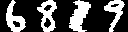

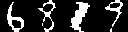

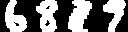

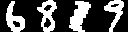

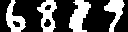

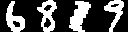

In [4]:
# EXAMPLE IMAGES
img = images[0][2]
img.save(disp)
img.erode().save(disp)
img.dilate().save(disp)
img.erode().dilate().save(disp)
img.dilate().erode().save(disp)
images[0][1].save(disp)

## Splitting Digits

We split the digits into individual image objects.

In [5]:
# EXTRACTING INDIVIDUAL DIGITS
digits = []
for img in images:
    digits.extend(get_individual_images(img))

### Number of Holes Detection

When inverting the image and counting the blobs minus the background we can count the number of holes in the digit. Whennot setting the min size of the blobs we would miss a lot of holes.

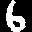

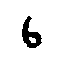

1

In [6]:
digits[0][2].save(disp)
digits[0][2].embiggen(2).invert().save(disp)
len(digits[3][2].embiggen(2).invert().findBlobs(minsize=3)[:-1])

We plot a set of images to check how the individual prepocessed images and labels look.

/usr/local/lib/python2.7/dist-packages/SimpleCV/ImageClass.py:1970: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._numpy != "":


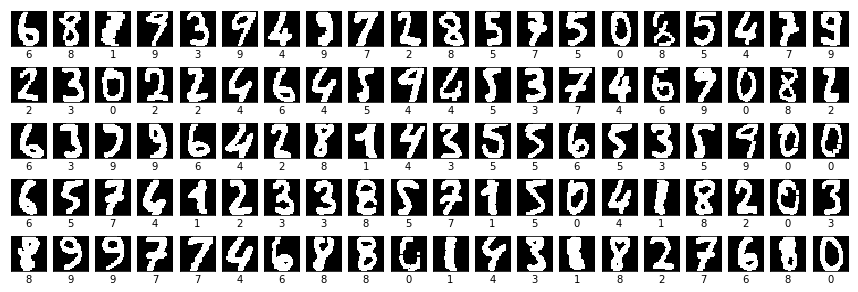

In [7]:
# PLOTTING IMAGES AND THEIR LABELS
PLOT_SIZE = 100
ROW_WIDTH = 20
plt.figure(figsize=(15, PLOT_SIZE / ROW_WIDTH))
for i in range(PLOT_SIZE):
    plt.subplot(PLOT_SIZE / ROW_WIDTH, ROW_WIDTH, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(digits[i][0])
    plt.imshow(digits[i][1].getNumpy(), cmap=plt.cm.binary)

# Save sample to an image
# plt.savefig('digits_sample', dpi=200, bbox_inches='tight')

## Create Pandas DataFrame with Labels and Image Objects

We also plot the frequency of the digits in the dataset.

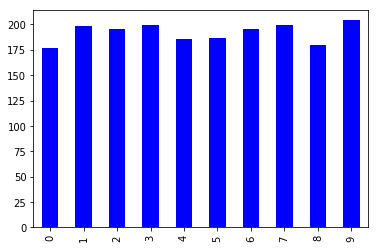

In [8]:
# CREATE DATAFRAME FROM DIGITS
columns = ['digit', 'image', 'image_raw']
data = pd.DataFrame(digits, columns=columns)
data_sorted = pd.DataFrame(sorted(digits), columns=columns)

# PLOT INTERESTING FEATURES
digit_counts = data.digit.value_counts()
digit_counts.sort_index(inplace=True)
digit_counts.plot(kind='bar')

## Low-Res Pixel Count Matrix

We want to create a feature that is based on the pixel count in cells of the image. We used a 4x4 grid (8x8 cells) before but lost too much detail. We use an 8x8 (4x4 cells) grid now.

This cell defines the function ans tests and plots the feature.

Low-Res Pixel Count Matrix based on binarized image


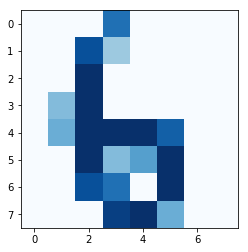


Low-Res Pixel Count Matrix based on binarized, dilated and eroded image


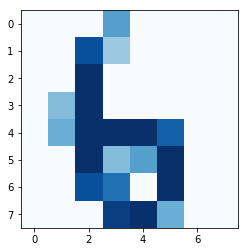

In [9]:
# WEIGHTED MATRIX CREATION
def get_weighted_matrix(img):
    COUNT = 8 # GRID SIZE
    T = 5 # THRESHOLD
    CROP = SIZE / COUNT
    m = np.zeros((COUNT, COUNT))
    for y in range(COUNT):
        for x in range(COUNT):
            part = img.crop(x * CROP, y * CROP, CROP, CROP)
            sum = (part.getNumpy()[:,:,0] / 255).sum()
            m[x][y] = sum if sum > T else 0
    return m.T


img_raw = data.image_raw[0]
img = data.image[0]

m_raw = get_weighted_matrix(img_raw)
print 'Low-Res Pixel Count Matrix based on binarized image'
plt.imshow(m_raw, cmap='Blues', interpolation='nearest')
plt.show()

print

m = get_weighted_matrix(img)
print 'Low-Res Pixel Count Matrix based on binarized, dilated and eroded image'
plt.imshow(m, cmap='Blues', interpolation='nearest')
plt.show()

### Lines, Corners & Circles

We also tried to experiment with findLines, findCorners and findCircle but not a single image contains a line and the amount of corners in the images are not distinctive. Fortunately, circles did seem to be promosing.

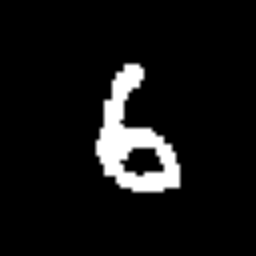

[SimpleCV.Features.Detection.Circle at (143,167), SimpleCV.Features.Detection.Circle at (127,147), SimpleCV.Features.Detection.Circle at (147,141)]


In [10]:
img = data_sorted.image[1300]
img = img.embiggen(2).scale(4)

img.save(disp)
img.show()

circles = img.findCircle(thresh=40, distance=20)
print circles
if circles:
    circles.draw()

blobs = img.findBlobs()
if len(blobs) > 0:
    blobs.draw()

# test_dict = {
#     'contours': [],
#     'corners': [],
#     'circles': [],
#     'label': []
# }

# for row in data.iterrows():
#     # HACK TO FIND BLOBS
#     row[1][1].show()
#     # Find blobs in the preprocessed image
#     blobs = row[1][1].findBlobs()
#     if blobs:
#         test_dict['contours'].append(len(blobs[0].contour()))
#         test_dict['corners'].append(len(row[1][1].findCorners()))
        
#         circles_set = row[1][1].embiggen(2).scale(4).findCircle(thresh=40, distance=20)
#         circles = 0
#         if circles_set:
#             circles = len(circles_set)
#         test_dict['circles'].append(circles)
        
#         test_dict['label'].append(row[1][0])

# # Create dataframe
# test_df = pd.DataFrame(test_dict, columns=['contours', 'corners', 'circles', 'label'])

In [11]:
test_df.groupby(test_df.label).mean()

,contours,corners,circles
label,,,
0,37.005650,29.790960,3.050847
1,34.000000,19.040404,0.075758
2,45.410256,23.164103,1.215385
3,50.366834,23.035176,2.346734
4,53.973118,26.607527,1.134409
5,45.668449,23.133690,1.935829
6,40.384615,24.784615,2.005128
7,48.190955,22.532663,0.768844
8,40.666667,26.044444,2.472222


## Extracting Computer Vision Features and Saving to CSV

### Computer Vision based

- Area
  - Number of pixels in the blob.
- Contours
  - Number of contours in the blob.
- Corners
  - Number of corners in the image.
- Radius
  - Return the radius, the average distance of each contour point from the centroid.
- Circle Distance
  - Compare the hull mask to an ideal circle and count the number of pixels that deviate as a fraction of total area of the ideal circle.
- Rectangle Distance
  - This compares the hull mask to the bounding rectangle. Returns the area of the blob’s hull as a fraction of the bounding rectangle.
- Hull radius
  - Return the radius of the convex hull contour from the centroid.
- Aspect Ratio
  - Aspect ratio of the width and height of the blob.
- Centroid X
  - The x-coordinate of the centroid.
- Centroid Y
  - The y-coordinate of the centroid.
- Angle
  - The angle between the horizontal enclosing rectangle and the minimum enclosing rectangle of the blob.
- Corners
  - Number of corners found in the image.
- Circles
  - Number of circles found in the image.

### Self Computed Features

- Low-Res Pixel Count Matrix
  - The sum of pixels in a 4x4 cell of the image.
- Number of Holes
  - The number of holes found in the shape.


### Non-features

- Label
  - The correct digit.

First we create a dictionary to save all the features in.

In [12]:
# CREATING DICTIONARY TO SAVE ALL FEATURES IN

# Columns detected using computer vision
features_dict = {
    "area": [],
    "width": [],
    "contours": [],
    "radius": [],
    "circle_dist": [],
    "rect_dist": [],
    "hull_radius": [],
    "aspect_ratio": [],
    "centroid_x": [],
    "centroid_y": [],
    "angle": [],
    "corners": [],
    "circles": [],
    "num_holes": [],
    "label": []
}

# Reorder columns
column_order = [
    "area",
    "width",
    "contours",
    "radius",
    "circle_dist",
    "rect_dist",
    "hull_radius",
    "aspect_ratio",
    "centroid_x",
    "centroid_y",
    "corners",
    "circles",
    "angle"
]

# Adding column names for the low-res pixel count matrix
COUNT = 8
for x in range(COUNT):
    for y in range(COUNT):
        name = '_'.join(['weight', str(x), str(y)])
        column_order.append(name)
        features_dict[name] = []

column_order.append("num_holes")
column_order.append("label")

We then find and calculate all the features we want.

In [13]:
# Iterate through rows of the DataFrame
for row in data.iterrows():
    label = row[1][0]
    img = row[1][1]
    raw = row[1][2]
    img.show()
    
    # Find blobs in the preprocessed image
    blobs = img.findBlobs()
    if blobs:
        # Fractured digits
        if len(blobs) > 1:
            # Try again with more dilation
            img = img.dilate()
            blobs = img.findBlobs()
            if len(blobs) > 1:
                # Try again with raw image
                img = raw
                blobs = img.findBlobs()
                # Still fractured? Skip
                if len(blobs) > 1:
                    continue
        
        blob = blobs[0]
        features_dict['area'].append(blob.area())
        features_dict['width'].append(blob.width())
        features_dict['contours'].append(len(blob.contour()))
        features_dict['circle_dist'].append(blob.circleDistance())
        features_dict['rect_dist'].append(blob.rectangleDistance())
        features_dict['radius'].append(blob.radius())
        features_dict['hull_radius'].append(blob.hullRadius())
        features_dict['aspect_ratio'].append(blob.aspectRatio())
        features_dict['centroid_x'].append(blob.centroid()[0])
        features_dict['centroid_y'].append(blob.centroid()[1])
        features_dict['angle'].append(blob.angle())
        features_dict['corners'].append(len(img.findCorners()))
        
        # Finding the number of circles in an image
        circles_set = img.embiggen(2).scale(4).findCircle(thresh=40, distance=20)
        circles = 0
        if circles_set:
            circles = len(circles_set)
        features_dict['circles'].append(circles)

        # Calculate pixel count matrix in the preprocessed image
        m = get_weighted_matrix(img)
        COUNT = 8
        for x in range(COUNT):
            for y in range(COUNT):
                features_dict['_'.join(['weight', str(x), str(y)])].append(m[x, y])

        # Finding the number of holes in the 'just binarized' image
        num_holes = len(raw.embiggen(2).invert().findBlobs(minsize=3)[:-1])
        features_dict['num_holes'].append(num_holes)

        # Attach the correct label
        features_dict['label'].append(label)

# Create dataframe
data_frame = pd.DataFrame(features_dict, columns=column_order)

We reorder the columns of the DataFrame and save the file to CSV

In [14]:
# Save to CSV file
data_frame.to_csv('../dataset-numpy/dataset-v7.csv', sep=',', encoding='utf-8', index=False)

### Peeking into the Created Dataset

In [15]:
data_frame.groupby(data_frame.label).mean()

,area,width,contours,radius,circle_dist,rect_dist,hull_radius,aspect_ratio,centroid_x,centroid_y,...,weight_6_7,weight_7_0,weight_7_1,weight_7_2,weight_7_3,weight_7_4,weight_7_5,weight_7_6,weight_7_7,num_holes
label,,,,,,,,,,,,,,,,,,,,,
0,388.779661,19.796610,38.259887,11.870776,0.777770,0.083790,13.034776,0.684119,15.514661,15.849222,...,0.000000,0,0.000000,3.593220,13.502825,13.090395,4.870056,0.124294,0.000000,0.932203
1,270.823232,17.111111,34.085859,9.958356,1.164793,0.125550,13.371829,0.932315,15.965643,15.390697,...,0.106061,0,0.000000,1.540404,8.156566,12.161616,7.959596,1.606061,0.550505,0.000000
2,235.992308,20.912821,45.892308,9.756897,0.773286,0.117474,14.732701,0.644836,15.208349,16.731156,...,0.071795,0,0.082051,9.789744,13.789744,13.138462,12.246154,7.923077,0.523077,0.005128
3,237.283920,19.487437,51.050251,9.862909,0.909852,0.043312,14.196763,0.661723,16.888249,15.165510,...,0.000000,0,0.070352,8.964824,14.547739,12.899497,6.733668,0.683417,0.000000,0.000000
4,248.002688,21.290323,53.973118,9.164038,0.501170,0.183435,12.642562,1.261820,15.610866,16.109270,...,0.000000,0,0.000000,0.602151,5.661290,10.833333,1.731183,0.080645,0.037634,0.032258
5,234.566845,19.016043,46.647059,9.692429,0.972743,0.073314,13.866985,0.954613,14.987245,14.234905,...,0.000000,0,0.037433,8.058824,14.454545,10.272727,2.727273,0.187166,0.000000,0.010695
6,284.084615,19.958974,41.051282,10.637953,0.749967,0.167258,13.019047,0.608114,15.642559,18.978532,...,0.251282,0,0.000000,0.835897,10.200000,14.569231,12.958974,4.861538,0.092308,0.871795
7,236.489950,19.386935,48.190955,9.337271,0.803079,0.149348,13.477179,0.980296,16.800086,13.375708,...,0.000000,0,0.160804,7.396985,10.487437,0.633166,0.060302,0.000000,0.000000,0.000000
8,338.105556,18.927778,42.161111,10.245163,0.941357,0.065321,13.785627,0.784924,15.172695,15.364964,...,0.000000,0,0.000000,4.827778,13.194444,12.350000,6.072222,0.527778,0.000000,1.594444


In [16]:
data_frame.shape

(1920, 79)

In [17]:
data_frame.describe()

,area,width,contours,radius,circle_dist,rect_dist,hull_radius,aspect_ratio,centroid_x,centroid_y,...,weight_7_0,weight_7_1,weight_7_2,weight_7_3,weight_7_4,weight_7_5,weight_7_6,weight_7_7,num_holes,label
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,...,1920,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,274.982813,19.552604,44.460938,10.097489,0.840045,0.112436,13.522600,0.826547,15.873832,15.419765,...,0,0.035937,4.961979,11.565625,11.079167,6.225521,1.733333,0.122917,0.417187,4.532813
std,67.304109,2.133224,9.181315,0.975741,0.335181,0.070463,0.857668,0.458459,1.215348,1.929772,...,0,0.500401,5.585016,4.935527,5.523363,6.307037,4.132351,1.130143,0.606905,2.868122
min,136.500000,9.000000,18.000000,7.951196,0.265258,0.000000,11.249110,0.275862,11.911111,9.997567,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,228.875000,18.000000,38.000000,9.383102,0.642986,0.052239,12.910241,0.586207,15.053731,14.118958,...,0,0.000000,0.000000,10.000000,9.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,259.000000,20.000000,44.000000,9.934555,0.767127,0.105063,13.439518,0.620690,15.808951,15.314223,...,0,0.000000,0.000000,13.000000,12.000000,7.000000,0.000000,0.000000,0.000000,5.000000
75%,303.625000,21.000000,51.000000,10.629674,0.970649,0.169002,14.077269,0.689655,16.606884,16.465136,...,0,0.000000,10.000000,16.000000,16.000000,12.000000,0.000000,0.000000,1.000000,7.000000
max,532.000000,28.000000,83.000000,13.614818,3.879402,0.335774,16.812836,3.125000,20.294118,21.140118,...,0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,2.000000,9.000000


### Checking the Quality of the Number of Holes Feature

In [18]:
data_frame.groupby(['label','num_holes']).size()

label  num_holes
0      0             12
       1            165
1      0            198
2      0            194
       1              1
3      0            199
4      0            180
       1              6
5      0            185
       1              2
6      0             25
       1            170
7      0            199
8      0             13
       1             47
       2            120
9      0             34
       1            170
dtype: int64